<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 5px; height: 50px"> 

#   Personalizing Music Video Recommendations with Emotional Intelligence

> Capstone Project: Lionel Foo

---


#### <b> Notebook: 02C Classification Model (Multiclass Classification - RNN with GloVe Word Embeddings) </b>

<b>(a) Context: Rationale for Incorporating GloVe Word Embeddings</b>

Keras' default word vectorisation approach is non-semantic by nature (i.e., word vectors produced do not reflect how semantically close/far apart words are from each other). [1]

GloVe word embeddings will thus be incorporated in our model to enable semantic-based word vectorisation - with the view towards improving the classification model's performance. However, as GloVe's word embeddings are static (i.e., the same word will always have the same representation regardless of the context where it occurs - GloVe treats "apple" in "apple computers" and "apple juice" similarly) - word vectorisation with GloVe does not allow for context-driven semantic word vectorisation. [2] 

<font size="1.5">

References: 

[1] Towards Data Science. Text Classification using Word Embeddings and Deep Learning in Python - Classifying Tweets from .... 
<br>https://towardsdatascience.com/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81

[2] David Batista. Language Models and Contextualised Word Embeddings.
<br>https://www.davidsbatista.net/blog/2018/12/06/Word_Embeddings/

</font>

<br>
<b>(b) Incorporating GloVe Word Embeddings - Text-Preprocessing: Retention of Stop Words and No Lemmatisation</b>

A review of words within the GloVe repository reveals the presence of: 
* Stop words (e.g., "to", "but", "not")
* Words with similar lemmas that have different word vectors (e.g., "computer", "computerized", "supercomputers")

As such, stop words will be retained, and lemmatisation will not be performed. 

<br>
<b>(c) Notebook Outline</b>

1. Import Libraries, Data & Specify Random Seeds
2. Prepare Data for Modelling
3. Construct GloVe Word Embedding Matrix
4. Train Classification Model
5. Evaluate Classification Model
6. Comparison of Model Performance - Multinomial Classifier: w/out and w GloVe-based Word Vectoriser
7. Key Insights & Steps Going Forward


---

<b> 1. Import Libraries, Data & Specify Random Seeds </b>

In [1]:
# Imports: standard
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Imports: tensorflow for model building
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 4000

In [2]:
# Import data
df = pd.read_csv("Data/emotions_processed_dataset.csv")
df.head(3)

,text,label,emotion_name
0,i just feel really helpless and heavy hearted,4,Fear
1,i have enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing,0,Sadness
2,i gave up my internship with the dmrg and am feeling distraught,4,Fear


In [3]:
# Summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380365 entries, 0 to 380364
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   text          380365 non-null  object
 1   label         380365 non-null  int64 
 2   emotion_name  380365 non-null  object
dtypes: int64(1), object(2)
memory usage: 8.7+ MB


In [4]:
# Specify Random Seeds
np.random.seed(42)
tf.random.set_seed(42)


---

<b> 2. Prepare Data for Modelling </b>

Outline
* (a) Evaluate Class Imbalance
* (b) Perform Train-Test-Split
* (c) Address Class Imbalance
* (d) Tokenise & Pad Text Sequences

<b> (a) Evaluate Class Imbalance </b>

In [5]:
# Examine Class Imbalance
print("== Examine Class Imbalance ==\n")

# Counts
class_counts = df.groupby(['label', 'emotion_name']).size().reset_index(name='count')
print("= Counts =\n")
print(class_counts[['label', 'emotion_name', 'count']])

# Proportions
print("\n= Proportions =\n")
class_proportions = df.groupby(['label', 'emotion_name']).size() / len(df)
print(class_proportions)

== Examine Class Imbalance ==

= Counts =

   label emotion_name   count
0      0      Sadness  118152
1      1          Joy  134709
2      2         Love   29410
3      3        Anger   54597
4      4         Fear   43497

= Proportions =

label  emotion_name
0      Sadness         0.310628
1      Joy             0.354157
2      Love            0.077320
3      Anger           0.143538
4      Fear            0.114356
dtype: float64


Comments: Class Imbalance
* Class [0]: Sadness ; Class [1]: Joy, Class [2]: Love, Class [3]: Anger, Class [4]: Fear
* There are a disproportionately high number of "Sadness" (94522), "Joy" (107767), and "Anger" (43678) instances.
* There are a disproportionately low number of "Love" (23528) instances.

Comments: Approach to Addressing Class Imbalance
* Undersampling (oversampling) of the most (least) numerous class to attain a count equivalent to the "Fear" class (as it has a count between both classes), where we'll:
    * undersample: the most numerous classes ("Sadness", "Joy", and "Anger") 
    * oversample: the least numerous class ("Love")

* To prevent "training" data from leaking into the "testing" data - the class rebalancing procedure will be applied:
    * after the "train-test-split" step, and
    * applied to the "training" sample only

<b> (b) Perform Train-Test-Split </b>

In [6]:
# Split the dataset first
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

<br>
<b> (c) Address Class Imbalance </b>


In [7]:
# Balance the training dataset
class_4_size = train_df[train_df["label"] == 4].shape[0]
balanced_train_df = pd.concat([train_df[train_df["label"] == label].sample(n=class_4_size, replace=True, random_state=42) for label in train_df["label"].unique()], axis=0)

In [8]:
# Display the count of each unique label in the 'label' column of the balanced_train_df DataFrame after balancing
balanced_train_df['label'].value_counts()

label
1    34797
4    34797
3    34797
0    34797
2    34797
Name: count, dtype: int64

In [9]:
# Extract 'text' and 'label' columns from balanced_train_df for training
X_train_bal = balanced_train_df['text']
y_train_bal = balanced_train_df['label']
# Extract 'text' and 'label' columns from test_df for testing
X_test = test_df['text']
y_test = test_df['label']

# Print the data type of X_train_bal
print("X_train_bal data type:", X_train_bal.dtype)

X_train_bal data type: object


In [10]:
# Create copies of y_train_bal and y_test for later reference
y_train_bal_i = y_train_bal.copy()
y_test_i = y_test.copy()
# Convert categorical labels to one-hot encoded format
y_train_bal = pd.get_dummies(y_train_bal)
y_test      = pd.get_dummies(y_test)
# Display the shapes of the one-hot encoded label DataFrames
print("Shape y_train_bal:", y_train_bal.shape)
print("Shape y_test:", y_test.shape)

Shape y_train_bal: (173985, 5)
Shape y_test: (76073, 5)


<br>
<b> (d) Tokenise & Pad Text Sequences </b>

In [11]:
# Perform Tokenisation

# 1. Initialise tokeniser and fit tokeniser on training data 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_bal)

# 2. Use that tokenizer to transform (convert) the text message strings in training and test data into a list of integers where each integer represents the index of that word
X_train_bal_seq = tokenizer.texts_to_sequences(X_train_bal)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [12]:
# Pad Text Sequences

# 1. Obtain maximum length of text sequences in X_train and X_test set to 50 based on EDA done in Notebook 01
max_len = 50

# 2. Pad Text Sequences
X_train_bal_seq_padded = pad_sequences(X_train_bal_seq, max_len)
X_test_seq_padded = pad_sequences(X_test_seq, max_len)

# 3. Preview padded text sequence
print("Preview padded text sequence:")
print(X_test_seq_padded[0])

Preview padded text sequence:
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     1    21   468     8   813
    34 13845]


<br>

---

<b> 3. Construct GloVe Word Embedding Matrix </b>

As keras' default process to vectorise text sequencess is not semantics-based, a semantics-based approach utilising GloVe word embeddings will be adopted. 


(a) This step produces a GloVe Word Embedding Matrix required for semantics-based vectorisation, with guidance having been obtained from:
* Towards Data Science. Text Classification using Word Embeddings and Deep Learning in Python - Classifying Tweets from ... .
* <font size="1.5"> weblink: https://towardsdatascience.com/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81 </font>
<br>

(b) Details: GloVe Pre-Trained Word Embeddings Utilised
* As our data comprise twitter tweets, a GloVe Word Embedding that was pre-trained on 2 billion tweets will be utilised
* While word embedding vectors of dimensions 50d, 100d, & 200d are available, embeddings with <u>200d</u> will be used to capture finer differences between words' semantic meaning
* <font size="1.5"> weblink: https://nlp.stanford.edu/projects/glove/ </font>
* <font size="1.5"> download link: https://nlp.stanford.edu/data/glove.twitter.27B.zip </font>
<br>

(c) Broad Outline of Steps Required to Construct the GloVe Word Embedding Matrix
1. Recall tokenised "training" data
2. Create a parsimonious GloVe Word Embedding Matrix containing vectorised forms of the "training" data's tokens only 
    * i.e., other words within GloVe's word embeddings repository are excluded as they are not relevant to our analysis; and their exclusion allows us to conserve as much memory as possible
    * code for creating the parsimonious GloVe Word Embedding Matrix: drawn from the "Towards Data Science" article referenced above

In [13]:
# 1. Recall tokenised "training" data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_bal)

In [14]:
# 2. Define a class to create a parsimonious GloVe Word Embedding Matrix
# code source: https://towardsdatascience.com/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81

class Embeddings():

    # A class to read a given word embedding file and to create a parsimonious word embedding matrix

    def __init__(self, path, vector_dimension):
        self.path = path 
        self.vector_dimension = vector_dimension
    
    @staticmethod
    def get_coefs(word, *arr): 
        return word, np.asarray(arr, dtype='float32')

    def get_embedding_index(self):
        embeddings_index = dict(self.get_coefs(*o.split(" ")) for o in open(self.path, errors='ignore'))
        return embeddings_index

    def create_embedding_matrix(self, tokenizer, max_features):
    
        # A method to create the embedding matrix
        
        model_embed = self.get_embedding_index()

        embedding_matrix = np.zeros((max_features + 1, self.vector_dimension))
        for word, index in tokenizer.word_index.items():
            if index > max_features:
                break
            else:
                try:
                    embedding_matrix[index] = model_embed[word]
                except:
                    continue

        return embedding_matrix

In [15]:
# 3. Create parsimonious GloVe Word Embedding Matrix

embed_path = "Data/glove.twitter.27B.200d.txt"
embed_dim = 200  # corresponding to the number of dimensions per word in the GloVe repository above 

embedding = Embeddings(embed_path, embed_dim)
embedding_matrix = embedding.create_embedding_matrix(tokenizer, len(tokenizer.word_counts))


---

<b> 4. Train Classification Model </b>

1. Define Model
2. Define callbacks
3. Fit the RNN model

In [16]:
# 1. Define a RNN-LSTM model architecture using Keras
model = keras.models.Sequential([
    
    layers.Embedding(len(tokenizer.index_word)+1, embed_dim, weights=[embedding_matrix]),  # weights from: parsimonious GloVe Word Embedding Matrix

    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(512, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])
# Configure the model with Adam optimizer, categorical crossentropy loss, and accuracy as the evaluation metric
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         8512200   
                                                                 
 bidirectional (Bidirection  (None, 64)                59648     
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               33280     
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2

In [17]:
# 2. Define callbacks

# EarlyStopping callback to stop training if 'val_accuracy' doesn't improve for 10 consecutive epochs,
# Restoring the weights of the epoch with the best validation accuracy.
es = EarlyStopping(patience=10,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
 
# Reduce learning rate by a factor of 0.5 if 'val_loss' doesn't improve for 5 consecutive epochs.   
lr = ReduceLROnPlateau(patience = 5,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [18]:
# 3. Fit the RNN model
start_time = time.time()
history = model.fit(X_train_bal_seq_padded, y_train_bal,
                    validation_data=(X_test_seq_padded, y_test),
                    epochs=30,
                    verbose=1,
                    batch_size=32,
                    callbacks=[lr, es])
end_time = time.time()

Epoch 1/30


5438/5438 [==============================] - 147s 27ms/step - loss: 0.2656 - accuracy: 0.9315 - val_loss: 0.0879 - val_accuracy: 0.9685 - lr: 0.0010
Epoch 2/30
5438/5438 [==============================] - 145s 27ms/step - loss: 0.0723 - accuracy: 0.9774 - val_loss: 0.0994 - val_accuracy: 0.9690 - lr: 0.0010
Epoch 3/30
5438/5438 [==============================] - 142s 26ms/step - loss: 0.0513 - accuracy: 0.9843 - val_loss: 0.1199 - val_accuracy: 0.9668 - lr: 0.0010
Epoch 4/30
5438/5438 [==============================] - 151s 28ms/step - loss: 0.0380 - accuracy: 0.9891 - val_loss: 0.1211 - val_accuracy: 0.9687 - lr: 0.0010
Epoch 5/30
5438/5438 [==============================] - 152s 28ms/step - loss: 0.0296 - accuracy: 0.9920 - val_loss: 0.1235 - val_accuracy: 0.9690 - lr: 0.0010
Epoch 6/30
5438/5438 [==============================] - 156s 29ms/step - loss: 0.0247 - accuracy: 0.9935 - val_loss: 0.1301 - val_accuracy: 0.9683 - lr: 0.0010
Epoch 7/30
5438/5438 [=============================

In [19]:
print(f"Time taken to run the model: {end_time - start_time} seconds")

Time taken to run the model: 2738.0095427036285 seconds



---

<b> 5. Evaluate Classification Model </b>

(a) Evaluate loss and accuracy epoch-by-epoch

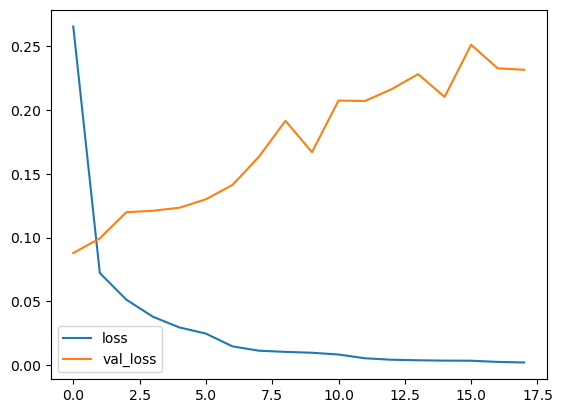

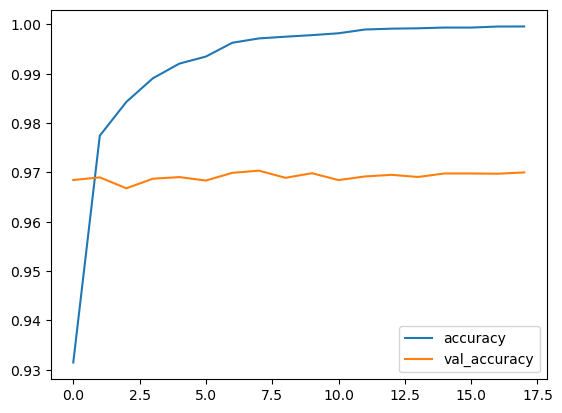

In [20]:
# Graph: loss and accuracy epoch-by-epoch
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [21]:
# Table: loss and accuracy epoch-by-epoch
history_df

,loss,accuracy,val_loss,val_accuracy,lr
0,0.265608,0.931471,0.087884,0.968451,0.001000
1,0.072261,0.977429,0.099413,0.968990,0.001000
2,0.051342,0.984275,0.119918,0.966769,0.001000
3,0.037973,0.989062,0.121057,0.968714,0.001000
4,0.029551,0.992045,0.123452,0.969043,0.001000
5,0.024738,0.993471,0.130067,0.968346,0.001000
6,0.014715,0.996276,0.141262,0.969911,0.000500
7,0.011306,0.997149,0.163428,0.970344,0.000500
8,0.010399,0.997500,0.191642,0.968898,0.000500
9,0.009698,0.997816,0.167012,0.969832,0.000500


In [22]:
# Identify best epoch
best_epoch = np.argmax(history.history['val_accuracy']) + 1
print("Best epoch: ", best_epoch)

Best epoch:  8


(b) Obtain model evaluation metrics

In [23]:
# Define function: generate predicted classes as a numpy array

def pred_class(pred_prob_varname):

    pred_class_all = np.array([])
    for pred_prob_array in pred_prob_varname:
        pred_class = np.argmax(pred_prob_array)
        pred_class_all = np.append(pred_class_all, pred_class)
    
    return pred_class_all

In [24]:
# Obtain predicted probabilities and classes
y_train_pred_prob  = model.predict(X_train_bal_seq_padded)
y_train_pred_class = pred_class(y_train_pred_prob)

y_test_pred_prob  = model.predict(X_test_seq_padded)
y_test_pred_class = pred_class(y_test_pred_prob)

2378/2378 [==============================] - 9s 4ms/step


In [25]:
y_train_bal_i.unique()

array([1, 4, 3, 0, 2])

In [26]:
# Print model evaluation metrics: "training" data
print("== Classification Report: Training Data ==", "\n")
print(classification_report(y_train_bal_i, y_train_pred_class, target_names = ["Sadness", "Joy", "Love", "Anger", "Fear"]))

== Classification Report: Training Data == 

              precision    recall  f1-score   support

     Sadness       1.00      1.00      1.00     34797
         Joy       1.00      1.00      1.00     34797
        Love       1.00      1.00      1.00     34797
       Anger       1.00      1.00      1.00     34797
        Fear       1.00      1.00      1.00     34797

    accuracy                           1.00    173985
   macro avg       1.00      1.00      1.00    173985
weighted avg       1.00      1.00      1.00    173985



In [27]:
y_test_i.unique()

array([1, 4, 0, 3, 2])

In [28]:
# Print model evaluation metrics: "testing" data
print("== Classification Report: Testing Data ==", "\n")
print(classification_report(y_test_i, y_test_pred_class, target_names = ["Sadness", "Joy", "Love", "Anger", "Fear"]))

== Classification Report: Testing Data == 

              precision    recall  f1-score   support

     Sadness       0.99      0.98      0.98     23630
         Joy       0.99      0.97      0.98     26942
        Love       0.88      0.96      0.91      5882
       Anger       0.96      0.97      0.96     10919
        Fear       0.96      0.97      0.96      8700

    accuracy                           0.97     76073
   macro avg       0.95      0.97      0.96     76073
weighted avg       0.97      0.97      0.97     76073



**Comments**

(a) Evaluation Metrics of Interest

* **Accuracy**: This is the percentage of predictions that are correct. It provides a general measure of how well the model performs across all classes.

* **F1-Score**: This is a composite measure that considers both precision and recall. It provides a balance between the need to accurately identify positive instances (precision) and the need to cover as much of the positive instances as possible (recall).
    * **Precision**: This is the percentage of predicted positives that are true. A low precision score on detecting a particular emotion indicates that the model is wrongly classifying other emotions as that particular emotion.
    * **Recall**: This is the percentage of actual positives that are predicted correctly. A high recall score is desirable as it indicates that the model is able to identify a high proportion of instances for each emotion.

Performance on: "Training" Data
* The model exhibits perfect performance on the training data across all classes (Sadness, Joy, Love, Anger, Fear), with precision, recall, f1-score, and overall accuracy all being 1.00. This could be indicative of overfitting, as it suggests that the model has learned the training data perfectly.

Performance on: "Testing" Data
* Despite the potential overfitting suggested by the training data results, the model's performance on the testing data is quite good, with an overall accuracy of 0.97. This indicates that the model generalizes well to unseen data.
* There are some differences in performance across the classes:
    * For the classes Sadness, Joy, Anger, and Fear, the model performs very well with precision, recall, and f1-scores all above 0.96.
    * For the Love class, the precision is slightly lower at 0.88, but the recall is quite high at 0.96. This suggests that the model is able to correctly identify most of the actual Love instances, but it also incorrectly identifies some instances of other classes as Love.

In conclusion, despite the potential overfitting suggested by the training data results, the model's good performance on the testing data indicates that it generalizes well to unseen data.


---

<b> 6. Comparison of all 5 Model Performance - Distilbert vs Naive Bayes vs Logistic Regression vs XG Boost vs RNN with Glove Word Embeddings </b>

<br>

(a) DistilBert

|Multinomial|Train Accuracy|Test Precision|Test Recall|Test F1-Score|Test Accuracy|Support|Time seconds|
|---|---|---|---|---|---|---|---|
|Class 0: Sadness|---|0.65|0.55|0.59|---|23630|---|
|Class 1: Joy|---|0.78|0.61|0.68|---|26942|---|
|Class 2: Love|---|0.34|0.42|0.38|---|5882|---|
|Class 3: Anger|---|0.48|0.52|0.50|---|10919|---|
|Class 4: Fear|---|0.38|0.70|0.49|---|8700|---|
|Overall|0.44|---|---|---|0.57|76073|30534|

<br>

<br>

(b) Naive Bayes

|Multinomial|Train Accuracy|Test Precision|Test Recall|Test F1-Score|Test Accuracy|Support|Time seconds|
|---|---|---|---|---|---|---|---|
|Class 0: Sadness|---|0.97|0.93|0.95|---|23630|---|
|Class 1: Joy|---|0.97|0.90|0.94|---|26942|---|
|Class 2: Love|---|0.74|0.96|0.84|---|5882|---|
|Class 3: Anger|---|0.91|0.95|0.93|---|10919|---|
|Class 4: Fear|---|0.88|0.96|0.92|---|8700|---|
|Overall|0.95|---|---|---|0.93|76073|1497|

<br>

<br>

(c) Logistic Regression

|Multinomial|Train Accuracy|Test Precision|Test Recall|Test F1-Score|Test Accuracy|Support|Time seconds|
|---|---|---|---|---|---|---|---|
|Class 0: Sadness|---|0.97|0.94|0.96|---|23630|---|
|Class 1: Joy|---|0.97|0.93|0.95|---|26942|---|
|Class 2: Love|---|0.81|0.98|0.89|---|5882|---|
|Class 3: Anger|---|0.93|0.95|0.94|---|10919|---|
|Class 4: Fear|---|0.92|0.96|0.94|---|8700|---|
|Overall|0.97|---|---|---|0.94|76073|1043|

<br>

(d) XG Boost

|Multinomial|Train Accuracy|Test Precision|Test Recall|Test F1-Score|Test Accuracy|Support|Time seconds|
|---|---|---|---|---|---|---|---|
|Class 0: Sadness|---|0.95|0.91|0.93|---|23630|---|
|Class 1: Joy|---|0.96|0.92|0.94|---|26942|---|
|Class 2: Love|---|0.78|0.99|0.87|---|5882|---|
|Class 3: Anger|---|0.93|0.92|0.92|---|10919|---|
|Class 4: Fear|---|0.89|0.96|0.92|---|8700|---|
|Overall|0.95|---|---|---|0.93|76073|2010|

<br>

<br>

(e) RNN with Glove Word Embeddings

|Multinomial|Train Accuracy|Test Precision|Test Recall|Test F1-Score|Test Accuracy|Support|Time seconds|
|---|---|---|---|---|---|---|---|
|Class 0: Sadness|---|0.99|0.98|0.98|---|23630|---|
|Class 1: Joy|---|0.99|0.97|0.98|---|26942|---|
|Class 2: Love|---|0.88|0.96|0.91|---|5882|---|
|Class 3: Anger|---|0.96|0.97|0.96|---|10919|---|
|Class 4: Fear|---|0.96|0.97|0.96|---|8700|---|
|Overall|1.00|---|---|---|0.97|76073|2738|

<br>

# Emotion Classification Models Evaluation

We trained five different models to classify text into five emotions: Sadness, Joy, Love, Anger, and Fear. The models were evaluated based on their F1-Score, Test Accuracy, and efficiency (time to run each model).

## Evaluation Metrics

1. **Accuracy**: This metric is particularly important in this case because we have a multi-class problem. A high accuracy means that the model is good at predicting the correct emotion class out of the five possible classes. 

2. **F1-Score**: This metric is crucial for this task because it balances precision and recall. In the context of emotion classification, precision means the percentage of correct predictions for a particular emotion out of all predictions for that emotion, while recall is the percentage of correct predictions for a particular emotion out of all actual instances of that emotion. The F1-score is particularly useful if we want to have a balance between identifying as many instances of each emotion as possible (high recall) and keeping the number of incorrect predictions low (high precision).

3. **Efficiency**: This is important because we want the model to be able to process text quickly, especially if we’re dealing with large amounts of data. A model that takes too long to make predictions might not be practical for this use case.

## Models Evaluation

### Naive Bayes
The model has a high overall accuracy and F1-score, which suggests that it’s good at identifying the correct emotion class. However, the F1-score for the ‘Love’ class is relatively low, which means the model might struggle to correctly identify this emotion. The model is also relatively efficient, with a runtime of 1497 seconds.

### Logistic Regression
The Logistic Regression model outperformed the Naive Bayes model with an overall test accuracy of 0.94 and improved F1-Scores across all classes. It also has a high F1-score for all individual classes, including ‘Love’. Moreover, it’s more efficient than the Naive Bayes model, with a runtime of 1043 seconds.

### XG Boost
This model has a similar overall accuracy and F1-score to the Naive Bayes model. However, it’s less efficient, with a runtime of 2010 seconds. The F1-score for the ‘Love’ class is higher than for the Naive Bayes model, but lower than for the Logistic Regression model.

### Distilbert
This model performed really poorly with an overall low accuracy and F1-score. Moreover, it’s computationally intensive, with a runtime of 30534 seconds.

### RNN with Glove Word Embeddings
This is the best performing model in terms which had the higest overall accuracy and F1-score, suggesting that it’s the best at identifying the correct emotion class. It is however relatively more computationally intensive than the non-neural network models with a runtime of 2738 secondes.


### Based on the results, the RNN model using GloVe word embeddings had the best performance. This model is preferred because it combines the strengths of RNNs and GloVe embeddings.
- RNNs (Recurrent Neural Networks) are capable of capturing the sequential information present in the text data, which is crucial for understanding the context of words in a sentence. On the other hand, GloVe (Global Vectors for Word Representation) is an unsupervised learning algorithm for obtaining vector representations for words. These embeddings can capture semantic relationships between words, which is beneficial for our task.

- However, it’s important to note that while GloVe embeddings capture semantic relationships between words, they are static and do not take into account the context in which a word appears. This means that the same word will have the same representation regardless of its context. For example, the word “apple” would have the same representation in “apple computers” and “apple juice”. Therefore, while the combination of RNNs and GloVe embeddings can capture some level of context, it may not fully capture context-driven semantic word vectorisation.


---

<b> 7. Future Work </b>

##### While the DistilBERT model, a transformer-based model, was expected to perform well due to its ability to understand the semantic meaning of words based on their context, it did not meet expectations. Potential reasons could be the model’s complexity and the possibility of insufficient training. Future work could explore tuning the DistilBERT model or providing it with more training data to improve its performance. 



---


---

<b> 8. Export Model and Tokenizer </b>

In [29]:
import os
import pickle

# Create 'Model' directory if it doesn't exist
if not os.path.exists('Model'):
    os.makedirs('Model')

# Save the tokenizer
with open('Model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
model.save('Model/model_emotions.keras')